In [216]:
import pandas as pd

In [217]:
df = pd.read_csv('labeling/fresh_data.csv').set_index('id')
df = df.drop(['title', 'highlight', 'content', 'media_desc'], axis = 1)

In [218]:
df.head(3)

,div,date,author,media_type,replies,upvotes,downvotes,rage,joy,sadness,surprise,fear,reactions,reactions_sentiment
id,,,,,,,,,,,,,,
24760624,cyrk,2019-05-08 07:02:00,Anna Dobiegała,image,5,51,9,0,0,0,0,0,60,0.85
24788214,porodówka,2019-05-15 16:30:00,mag,image,5,52,27,0,0,0,0,0,79,0.66
24801435,Świat,2019-05-19 08:43:00,Maciej Czarnecki,image,15,82,27,0,0,0,0,0,109,0.75


## Data preparation

In [219]:
labels_columns = ['replies', 'upvotes', 'downvotes', 'rage', 'joy', 'sadness', 'surprise', 
                  'fear', 'reactions', 'reactions_sentiment']
labels_df = df[labels_columns]
df = df.drop(labels_columns, axis = 1)

In [220]:
def process_dates(df):
    df['date'] = pd.to_datetime(df['date'])
    df = pd.concat([
        df,
        pd.get_dummies(df['date'].dt.weekday, prefix = 'weekday'),
        pd.get_dummies(df['date'].dt.hour, prefix = 'hour'),
    ], axis = 1)
    df = df.drop('date', axis = 1)
    return df

In [221]:
df = process_dates(df)

In [222]:
df.shape

(1090, 32)

In [223]:
def process_author_div_and_media_type(df):
    df = pd.concat([
        df,
        pd.get_dummies(df['author'], prefix = 'author'),
        pd.get_dummies(df['div'], prefix = 'div'),
        pd.get_dummies(df['media_type'], prefix = 'media_type')
    ], axis = 1)
    df = df.drop(['author', 'div', 'media_type'], axis = 1)
    return df

In [224]:
df = process_author_div_and_media_type(df)

In [225]:
df.shape

(1090, 697)

In [226]:
def add_vectors(columns):
    column_vectors = []
    for column in columns:
        tmp = pd.read_csv('labeling/'+column+'_vec').set_index('id')
        tmp.columns = [column+"_"+x for x in tmp.columns]
        column_vectors.append(tmp)
    return pd.concat(column_vectors, axis = 1)

In [227]:
df = pd.concat([df, add_vectors(['content', 'highlight', 'title', 'media_desc'])], axis = 1)

In [228]:
df.shape

(1090, 1897)

In [229]:
from json import load
import numpy as np
from collections import Counter

In [230]:
with open('labeling/idf_dict', 'r') as f:
    idf = load(f)
    idf_voc = idf.keys()

In [231]:
lemmas = pd.read_csv('labeling/lemmatized_articles.csv').set_index('id').fillna('')

In [232]:
lemmas.head(1)

,content,highlight,media_desc,title
id,,,,
24760624,wtorek gdansku wystapil cyrk zalewski udzialem...,mieszkancy osowa chca okno wystepowal cyrk zwi...,,cyrk zwierzetami gdansku mieszkancy oburzony b...


In [233]:
def add_tf_idf(columns):
    whole_string = ''
    for column in columns:
        whole_string = whole_string + lemmas[column] + ' '
    tf_idf = []
    for record in whole_string.values:
        return_record = []
        counts = dict(Counter(record.split(' ')))
        for feature_word in idf_voc:
            if feature_word in counts.keys():
                return_record.append(counts[feature_word]/idf[feature_word])
            else:
                return_record.append(0)
        tf_idf.append(return_record)
        
    tmp = pd.DataFrame(tf_idf, index = lemmas.index)
    tmp.columns = ['tf_idf_'+x for x in idf_voc]
    
    return tmp

In [234]:
df = pd.concat([df, add_tf_idf(['content', 'highlight', 'title', 'media_desc'])], axis = 1)

In [235]:
df.shape

(1090, 11052)

In [236]:
labels_df.shape

(1090, 10)

## Categorize labels

In [237]:
labels_df.head(3)

,replies,upvotes,downvotes,rage,joy,sadness,surprise,fear,reactions,reactions_sentiment
id,,,,,,,,,,
24760624,5,51,9,0,0,0,0,0,60,0.85
24788214,5,52,27,0,0,0,0,0,79,0.66
24801435,15,82,27,0,0,0,0,0,109,0.75


In [238]:
import matplotlib.pyplot as plt

128.54999999999995
2584.8499999999995
257.54999999999995
2740.8499999999985


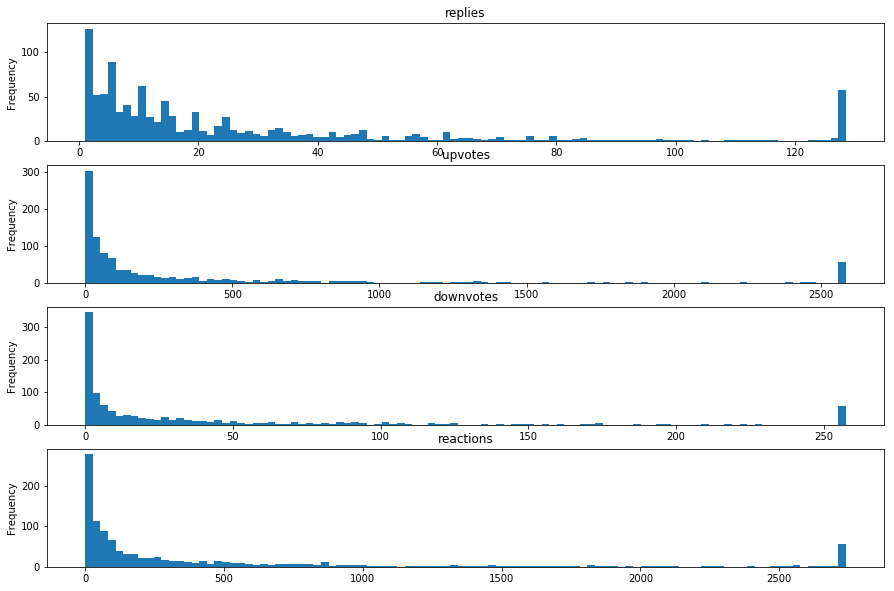

In [239]:
fig, axes = plt.subplots(4)
for i, column in enumerate(['replies', 'upvotes', 'downvotes', 'reactions']):
    threshold = labels_df[column].quantile(0.95)
    print(threshold)
    labels_df.loc[labels_df[column] > threshold, column] = threshold
    labels_df[column].plot(kind = 'hist', bins = 100, figsize= (15,10), title = column, ax = axes[i])

In [251]:
categories = []
categories_columns = ['replies', 'upvotes', 'downvotes', 'reactions', 'reactions_sentiment']
for column in categories_columns:
    categories.append(pd.qcut(labels_df[column], 3, labels = [-1, 0, 1]))
tmp_cat = pd.concat(categories, axis = 1)
tmp_cat.columns = [x+"_cat" for x in categories_columns]
labels_df = pd.concat([labels_df, tmp_cat], axis = 1)

In [252]:
labels_df.head(3)

,replies,upvotes,downvotes,rage,joy,sadness,surprise,fear,reactions,reactions_sentiment,replies_cat,upvotes_cat,downvotes_cat,reactions_cat,reactions_sentiment_cat
id,,,,,,,,,,,,,,,
24760624,5.0,51.0,9.0,0,0,0,0,0,60.0,0.85,-1,0,0,0,0
24788214,5.0,52.0,27.0,0,0,0,0,0,79.0,0.66,-1,0,0,0,-1
24801435,15.0,82.0,27.0,0,0,0,0,0,109.0,0.75,0,0,0,0,-1


In [261]:
for emotion in ['rage', 'joy', 'sadness', 'surprise', 'fear']:
    labels_df.loc[labels_df[emotion] == 0, emotion+'_cat'] = 0
    labels_df.loc[labels_df[emotion] != 0, emotion+'_cat'] = 1

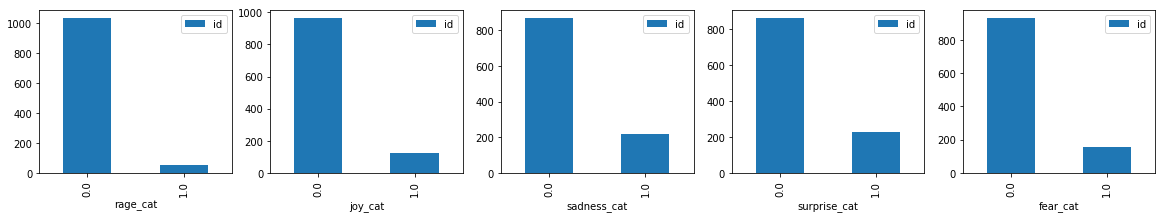

In [271]:
fig, axes = plt.subplots(1, 5, figsize = (20,3))
for i, emotion_cat in enumerate(['rage_cat', 'joy_cat', 'sadness_cat', 'surprise_cat', 'fear_cat']):
    labels_df[[emotion_cat]].reset_index().groupby(emotion_cat).count().plot(kind = 'bar', ax = axes[i])

## Normalize labels

In [ ]:
# if emotions are selected

### Define label

In [276]:
selected_label = 'replies_cat'

## Features selection

In [277]:
X = df.values

In [278]:
Y = labels_df[[selected_label]].values

In [279]:
from sklearn.ensemble import ExtraTreesClassifier

In [282]:
clf = ExtraTreesClassifier(n_estimators=50, max_depth = int(len(df)*0.05), min_samples_split = int(len(df)*0.05))

In [283]:
clf = clf.fit(X, Y)

/home/jacek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [285]:
all_features = df.columns

In [286]:
important_feaures_indexes = clf.feature_importances_  

In [291]:
importance_threshold = important_feaures_indexes.mean() * 0.5

In [298]:
selected_columns = all_features[[True if x > importance_threshold else False for x in important_feaures_indexes]]

In [300]:
len(all_features)

11052

In [299]:
X = df[selected_columns].values

In [301]:
len(selected_columns)

2620

## Define X and Y

In [314]:
s = int(len(df)*0.9)

In [315]:
s

981

In [317]:
train_x = X[:s]
train_y = Y[:s]

In [318]:
test_x = X[s:]
test_y = Y[s:]

## Training

In [302]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu

In [303]:
inputs = Input(shape = (len(selected_columns), ))

In [305]:
hidden_1 = Dense(int(len(selected_columns)/100), activation = relu)(inputs)
hidden_2 = Dense(int(len(selected_columns)/200), activation = relu)(hidden_1)

In [307]:
outputs = Dense(1)(hidden_2)

In [308]:
model = Model(
    inputs = inputs,
    outputs = outputs
)

In [309]:
from tensorflow.keras.optimizers import RMSprop

In [310]:
optimizer = RMSprop(0.01)

In [311]:
from tensorflow.losses import *

In [312]:
model.compile(
    loss=mean_squared_error,
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

W0715 22:45:22.281595 140275591612224 deprecation.py:323] From /home/jacek/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [319]:
example_batch = test_x[:5]
print(model.predict(example_batch))

[[-0.02289056]
 [ 0.08941911]
 [-0.07314759]
 [ 0.0876969 ]
 [ 0.03700279]]


In [320]:
EPOCHS = 300

In [321]:
from tensorflow.keras.callbacks import EarlyStopping

In [322]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [323]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2620)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 26)                68146     
_________________________________________________________________
dense_3 (Dense)              (None, 13)                351       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 14        
Total params: 68,511
Trainable params: 68,511
Non-trainable params: 0
_________________________________________________________________


In [324]:
history = model.fit(
    train_x, train_y,
    epochs=EPOCHS,
    validation_split = 0.15, 
    verbose=0,
    callbacks=[early_stop],
)

In [325]:
import pandas as pd
import matplotlib.pyplot as plt

In [326]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [327]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [328]:
mae

0.6503282

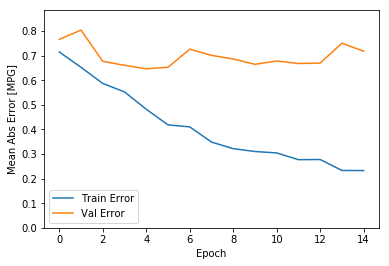

In [329]:
plot_history(history)

In [347]:
no_categories = len(res['real'].unique())

In [339]:
res = pd.concat([pd.DataFrame(model.predict(test_x)), pd.DataFrame(test_y)], axis = 1)
res.columns = ['prediction', 'real']

In [349]:
if no_categories == 2:
    res.loc[res['prediction'] < 0, 'prediction_cat'] = 0
    res.loc[res['prediction'] >= 0, 'prediction_cat'] = 1
elif no_categories == 3:
    res.loc[res['prediction'] < -0.66, 'prediction_cat'] = -1
    res.loc[res['prediction'] >  0.66, 'prediction_cat'] = 1
    res['prediction_cat'] = res['prediction_cat'].fillna(0)

In [356]:
res.loc[res['real'] == res['prediction_cat'], 'if_ok'] = 1
res['if_ok'] = res['if_ok'].fillna(0)

In [357]:
res.sample(frac=1).head(6)

,prediction,real,prediction_cat,if_ok
46,0.363401,0,0.0,1.0
9,0.425778,-1,0.0,0.0
1,-0.515262,-1,0.0,0.0
36,-0.178250,-1,0.0,0.0
0,-0.188153,1,0.0,0.0
65,0.444461,1,0.0,0.0


In [364]:
print('accuracy: ',round(res['if_ok'].sum()/len(res)*100, 2), '%')

accuracy:  33.03 %


In [367]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [370]:
if no_categories == 2:
    c = [0,1]
else:
    c = [-1,0,1]

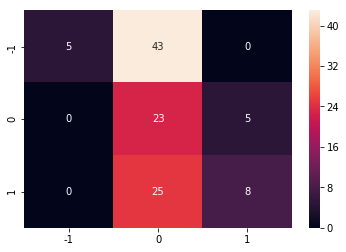

In [372]:
heatmap(confusion_matrix(res['real'], res['prediction_cat']), xticklabels = c, yticklabels = c, annot=True)